In [8]:
#Importing needed packages
import numpy as np
import astropy
import matplotlib.pyplot as plt
from helita.sim import rh15d
from astropy.io import fits
from matplotlib import cm
import h5py
from scipy.io import readsav
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.image import NonUniformImage
import tqdm
from scipy import integrate

In [2]:
#Define functions in the beginning of the programme
def radiation_temperature(lambda_ref, I_sp):
    """Compute the radiation/brightness temperature 
    from specific intensity"""
    h =6.62607015e-34 #J-s
    c = 3.0e8 #m/s
    k_b = 1.380649e-23 # J/K
    N_r = (h*c)/(lambda_ref*k_b)
    vary = (2*h*c**2)/(lambda_ref**5)
    D_r = np.log((vary/(I_sp*c/lambda_ref**2)+1))
    T_rad = N_r/D_r
    return T_rad

In [3]:
dpath_simulation ='/mn/stornext/d5/juanms/mpi3druns/2Druns/genohm/rain/l2d90x40rvk/sim_data_rh_it=280-369.hdf5'
input_sim = h5py.File(dpath_simulation,'r')

In [4]:
temp_juan=input_sim['temperature']
vel_juan=input_sim['velocity_z']
z    = input_sim['z']#Height (m)
x    = input_sim['x']#Spatial [m]
y    = input_sim['y']# time []

# Upflows

In [5]:
dpath_Ca = '/mn/stornext/u3/souvikb/rh_2019/rh/rh15d/run_Ca_Juan/output_upflows/'
dataCa_ray_aux = rh15d.Rh15dout(dpath_Ca)

/mn/stornext/u3/souvikb/.local/lib/python3.7/site-packages/helita-0.9.0-py3.7-linux-x86_64.egg/helita/sim/rh15d.py:40: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  setattr(self, g, xr.open_dataset(infile, group=g, autoclose=True))


--- Read /mn/stornext/u3/souvikb/rh_2019/rh/rh15d/run_Ca_Juan/output_upflows/output_aux.hdf5 file.
--- Read /mn/stornext/u3/souvikb/rh_2019/rh/rh15d/run_Ca_Juan/output_upflows/output_indata.hdf5 file.
--- Read /mn/stornext/u3/souvikb/rh_2019/rh/rh15d/run_Ca_Juan/output_upflows/output_ray.hdf5 file.


/mn/stornext/u3/souvikb/.local/lib/python3.7/site-packages/helita-0.9.0-py3.7-linux-x86_64.egg/helita/sim/rh15d.py:53: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  self.ray = xr.open_dataset(infile, autoclose=True)


In [6]:
#======= Declaring variables to be used for the computation========
I_sp = dataCa_ray_aux.ray.intensity
Chi_new = dataCa_ray_aux.ray.chi
S_new = dataCa_ray_aux.ray.source_function
Tau_ht_new = dataCa_ray_aux.ray.tau_one_height
I_sp.shape, S_new.shape, Tau_ht_new.shape, Chi_new.shape

((10, 3, 474), (10, 3, 1554, 188), (10, 3, 474), (10, 3, 1554, 188))

In [10]:
wave_Ca = dataCa_ray_aux.ray.wavelength
wave_Ca.shape
indices = np.arange(len(wave_Ca))[(wave_Ca > 391) & (wave_Ca < 399)]

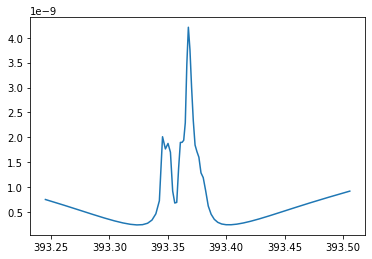

In [12]:
plt.plot(wave_Ca[indices[20:75]],I_sp[6,2,indices[20:75]])

In [13]:
#======= Computing optical depths at various frequencies ===========
N_x = 55 # this comes from selecting only those indices from the array "indices" that corresponds to only Ca K region.
N_y = len(dataCa_ray_aux.atmos.height_scale[6, 2].dropna('height'))#shape 
X_pix = 6
Y_pix = 2 #This is the time axis in 2.5D simulations because RH1.5D can't parallelize in time.
tau_lambda_new=np.zeros((55,N_y)) #140 is the wavelength, N_y is the height
for wl in range(55):
    height = dataCa_ray_aux.atmos.height_scale[X_pix, Y_pix].dropna('height')
    tau_lambda_test = integrate.cumtrapz(Chi_new[X_pix, Y_pix, :, 20+wl].dropna('height'), x=-height)
    tau_lambda_new[wl,:]= np.concatenate([[1e-20], tau_lambda_test])

## Factors to be included in the Contribution function analysis

In [15]:
chi_factor_new = (Chi_new[X_pix,Y_pix,:,20:75].dropna('height').T/tau_lambda_new)
tau_factor_new = tau_lambda_new*np.exp(-tau_lambda_new)
S_factor_new = S_new[X_pix,Y_pix,:,20:75].dropna('height').T
C_I = S_factor_new*tau_factor_new*chi_factor_new

## Spectral and spatial convolution

In [17]:
#Spatial convolution for each wavelength position per unit time with an FWHM of 0.08 arcsec
#Saptial sampling of the simulation is ~4 km and the spatial resolution of CHROMIS is ~60 km. Assuming an FWHM of 60 km, leads to a standard
# deviation that is given by 60/2.335 km ~ 7 pixels in the x direction in the simulation. Hence defining a Gaussian kernel with a std dev =7
# Performing a 1D spatial convolution for all x position per unit time for each wavelength position with the Astropy convolve function.
from astropy.convolution import Gaussian1DKernel,convolve
gauss_kernel = Gaussian1DKernel(2)
space_conv_CaK = np.zeros((10,3,55)) #Same as (10, 3, 55)
#space_conv_tau_Cak = np.zeros((10,3,55))
for time in range(3):
    for wav in range(55):
        space_conv_CaK[:,time,wav] = convolve(I_sp[:,time,indices[wav+20]],gauss_kernel,normalize_kernel=True,boundary='extend')
 #       space_conv_tau_Cak[:,time,wav] = convolve(tau_comb[:,time,indices[wav+20]],gauss_kernel,normalize_kernel=True,boundary='extend')

In [19]:
#Spectral convolution per time step per unit x-position.
# First spatial smeraing and then spectral smearing as per the light path in the telescope.
F_tran=readsav('/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/crispex/09:12:00/Ca_K_FP_profile2.sav')
FP=np.array(F_tran['res2'])
FP= FP/np.sum(FP)
# F_tran_8542=readsav('/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/crispex/09:12:00/Ca_8542_FP_profile.sav')
# FP_8542=np.array(F_tran_8542['tr1'])
# FP_8542= FP_8542/np.sum(FP_8542)
# spec_conv_Ca_8542 = np.zeros((size_intensity[0],size_intensity[1],83))
spec_conv_CaH_K = np.zeros((10,3,55))
# spec_conv_tau_Cak = np.zeros((size_intensity[0],size_intensity[1],55))
# spec_conv_tau_Ca8542 = np.zeros((size_intensity[0],size_intensity[1],83))
for time in range(3):
    for x_space in range(10):
        spec_conv_CaH_K[x_space,time,:]=convolve(space_conv_CaK[x_space,time,:],FP,boundary='extend')
#         spec_conv_tau_Cak[x_space,time,:]=convolve(space_conv_tau_Cak[x_space,time,:],FP,boundary='extend')
#         spec_conv_Ca_8542[x_space,time,:]=convolve(space_conv_Ca8542[x_space,time,:],FP_8542,boundary='extend')
#         spec_conv_tau_Ca8542[x_space,time,:]=convolve(space_conv_tau_Ca8542[x_space,time,:],FP_8542,boundary='extend')
        

In [20]:
spec_conv_CaH_K.shape

(10, 3, 55)

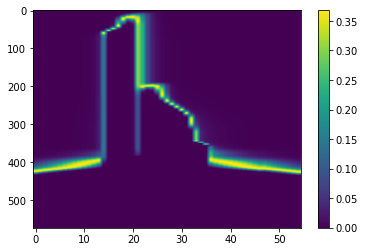

In [23]:
plt.imshow(tau_factor_new.T,aspect='auto')
plt.colorbar()

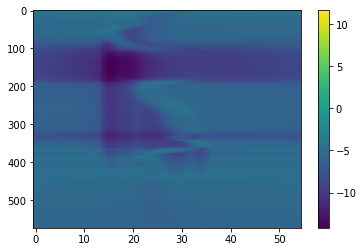

In [29]:
plt.imshow(np.log10(chi_factor_new).T,aspect='auto')
plt.colorbar()

In [30]:
z1 = z[0,:]/1e6
z1.shape
dopp_cak = ((wave_Ca[indices[20:75]]-393.37)/393.37)*3e5
x1 = dopp_cak
extend = (x1.min(),x1.max(),z1.max(),z1.min())

In [32]:
#======== Converting specific intensity to brightness temperature ======##
T_brightness = np.zeros((55))
for wl in range(55):
    T_brightness[wl] = radiation_temperature(lambda_ref=wave_Ca[indices[20+wl]]*1e-9, I_sp=np.mean(spec_conv_CaH_K[X_pix-1:X_pix+1,Y_pix,wl],axis=0))

## Ca II ionization 

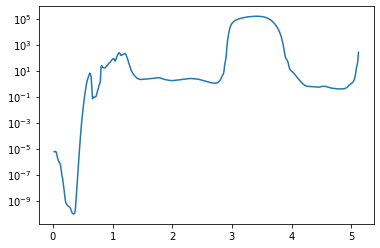

In [53]:
continuum = dataCa_ray_aux.atom_CA.populations[5,X_pix,Y_pix,980:1410]
tot_caII = np.sum(dataCa_ray_aux.atom_CA.populations[0:4,X_pix,Y_pix,980:1410],axis=0)

plt.plot(z1[980:1410],continuum/tot_caII)
plt.yscale('log')

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_innches" which is no longer supported as of 3.3 and will become an error two minor releases later


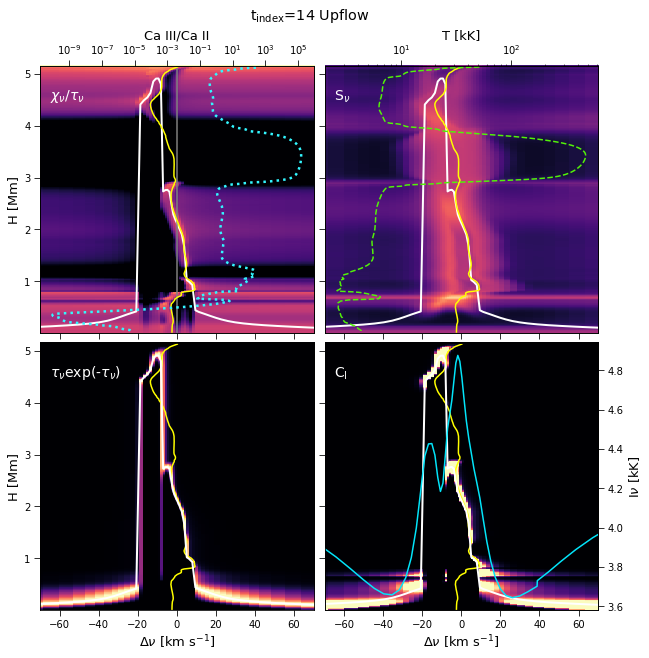

In [52]:
xdopp_minmax=[-70,70]
cmap1 = 'magma'
fig, axs =plt.subplots(2,2,figsize=(10,10),facecolor='w', edgecolor='k')
fig.suptitle(r't$_{\mathrm{index}}$=14 Upflow',va='center',y=0.95,size='x-large')
fig.subplots_adjust(hspace = 0.04,wspace=0.04)
axs=axs.ravel()

norm1 = cm.colors.Normalize(vmax=-3, vmin=-7)
im0 = NonUniformImage(axs[0], interpolation='nearest', extent=[xdopp_minmax[0],xdopp_minmax[1],z1[1410],z1[980]],cmap=cmap1,norm=norm1)
im0.set_data(x1,z1[:980:-1],np.flipud(np.squeeze(np.log10(chi_factor_new.T))))
axs[0].set_xlim(-70,70)
axs[0].set_ylim(z1[1410],5.15)
axs[0].images.append(im0)    
axs[0].plot(dopp_cak,Tau_ht_new[X_pix,Y_pix,indices[20:75]]/1e6,color='white',linewidth=2)
axs[0].axvline(x=0, color='gray')
axs[0].text(-65,4.5,r'$\chi_{\nu}$/$\tau_{\nu}$',color='white',size=14)
axs[0].plot(-1*vel_juan[0,4866,14,980:1410]/1e3,z1[980:1410],color='yellow')
axs[0].set_ylabel('H [Mm]',fontsize=13)
axs[0].set_xticklabels([])
axs[0].tick_params(direction='out', length=6,color='black')

ax0=axs[0].twiny()
#color ='tab:black'
ax0.set_xlabel(r'Ca III/Ca II',fontsize=13)
ax0.plot(continuum/tot_caII,z1[980:1410],color='#33F6FF', linestyle='dotted',linewidth=2.5)
ax0.set_xscale('log')
ax0.tick_params(direction='out', length=6,color='black')


norm2 = cm.colors.Normalize(vmax=-7.5,vmin=-10)
im1 = NonUniformImage(axs[1], interpolation='nearest', extent=[xdopp_minmax[0],xdopp_minmax[1],z1[1410],z1[980]],cmap=cmap1,norm=norm2)
im1.set_data(x1,z1[:980:-1],np.flipud(np.squeeze(np.log10(S_factor_new.T))))
axs[1].set_xlim(-70,70)
axs[1].set_ylim(z1[1410],5.15)
axs[1].images.append(im1)    
axs[1].plot(dopp_cak,Tau_ht_new[X_pix,Y_pix,indices[20:75]]/1e6,color='white',linewidth=2)
axs[1].text(-65,4.5,r'S$_{\nu}$',color='white',size=14)
axs[1].plot(-1*vel_juan[0,4866,14,980:1410]/1e3,z1[980:1410],color='yellow')
axs[1].tick_params(direction='out', length=6,color='black')
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])

ax2=axs[1].twiny()
#color ='tab:black'
ax2.set_xlabel('T [kK]',fontsize=13)
ax2.plot(temp_juan[0,4866,14,980:1410]/1e3,z1[980:1410],color='#52F208', linestyle='dashed')
ax2.set_xscale('log')
ax2.tick_params(direction='out', length=6,color='black')

norm3 = cm.colors.Normalize(vmax=0.35, vmin=0)
im2 = NonUniformImage(axs[2], interpolation='nearest', extent=[xdopp_minmax[0],xdopp_minmax[1],z1[1410],z1[980]],cmap=cmap1,norm=norm3)
im2.set_data(x1,z1[:980:-1],np.flipud(np.squeeze((tau_factor_new.T))))
axs[2].set_xlim(-70,70)
axs[2].set_ylim(z1[1410],5.15)
axs[2].images.append(im2)
axs[2].text(-65,4.5,r'$\tau_{\nu}$exp(-$\tau_{\nu}$)',color='white',size=14)
axs[2].plot(-1*vel_juan[0,4866,14,980:1410]/1e3,z1[980:1410],color='yellow')
axs[2].plot(dopp_cak,Tau_ht_new[X_pix,Y_pix,indices[20:75]]/1e6,color='white',linewidth=2)
axs[2].tick_params(direction='out', length=6,color='black')
axs[2].set_ylabel('H [Mm]',fontsize=13)
axs[2].set_xlabel(r'$\Delta$$\nu$ [km s$^{-1}$]',fontsize=13)

norm4 = cm.colors.Normalize(vmax=7e-16, vmin=0)
im3 = NonUniformImage(axs[3], interpolation='nearest', extent=[xdopp_minmax[0],xdopp_minmax[1],z1[1410],z1[980]],cmap=cmap1,norm=norm4)
im3.set_data(x1,z1[:980:-1],np.flipud(np.squeeze((C_I.T))))
axs[3].set_xlim(-70,70)
axs[3].set_ylim(z1[1410],5.15)
axs[3].images.append(im3)
axs[3].text(-65,4.5,r'C$_{\mathrm{I}}$',color='white',size=14)
axs[3].plot(-1*vel_juan[0,4866,14,980:1410]/1e3,z1[980:1410],color='yellow')
axs[3].plot(dopp_cak,Tau_ht_new[X_pix,Y_pix,indices[20:75]]/1e6,color='white',linewidth=2)
axs[3].tick_params(direction='out', length=6,color='black')
axs[3].set_yticklabels([])
axs[3].set_xlabel(r'$\Delta$$\nu$ [km s$^{-1}$]',fontsize=13)

ax3=axs[3].twinx()
#color ='tab:black'
ax3.set_ylabel(r'I$\nu$ [kK]',fontsize=13)
ax3.plot(dopp_cak,T_brightness/1e3,color='#03E5FA')
ax3.tick_params(direction='out', length=6,color='black')
plt.savefig('/mn/stornext/d9/souvikb/paper5_results/Cont_func_RBE_Ca.pdf',dpi=400,format='pdf',bbox_inches = 'tight',pad_innches=0.1)

# Downflows

In [55]:
dpath_Ca_DRRE = '/mn/stornext/u3/souvikb/rh_2019/rh/rh15d/run_Ca_Juan/output_downflows/'
dataCa_DRRE_ray_aux = rh15d.Rh15dout(dpath_Ca_DRRE)

/mn/stornext/u3/souvikb/.local/lib/python3.7/site-packages/helita-0.9.0-py3.7-linux-x86_64.egg/helita/sim/rh15d.py:40: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  setattr(self, g, xr.open_dataset(infile, group=g, autoclose=True))
/mn/stornext/u3/souvikb/.local/lib/python3.7/site-packages/helita-0.9.0-py3.7-linux-x86_64.egg/helita/sim/rh15d.py:53: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  self.ray = xr.open_dataset(infile, autoclose=True)


--- Read /mn/stornext/u3/souvikb/rh_2019/rh/rh15d/run_Ca_Juan/output_downflows/output_aux.hdf5 file.
--- Read /mn/stornext/u3/souvikb/rh_2019/rh/rh15d/run_Ca_Juan/output_downflows/output_indata.hdf5 file.
--- Read /mn/stornext/u3/souvikb/rh_2019/rh/rh15d/run_Ca_Juan/output_downflows/output_ray.hdf5 file.


In [94]:
#======= Declaring variables to be used for the computation========
I_sp_DRRE = dataCa_DRRE_ray_aux.ray.intensity
Chi_new_DRRE = dataCa_DRRE_ray_aux.ray.chi
S_new_DRRE = dataCa_DRRE_ray_aux.ray.source_function
Tau_ht_new_DRRE = dataCa_DRRE_ray_aux.ray.tau_one_height
I_sp_DRRE.shape, S_new_DRRE.shape, Tau_ht_new_DRRE.shape, Chi_new_DRRE.shape

((10, 6, 474), (10, 6, 1554, 188), (10, 6, 474), (10, 6, 1554, 188))

In [95]:
#======= Computing optical depths at various frequencies ===========
N_x = 55 # this comes from selecting only those indices from the array "indices" that corresponds to only Ca K region.
N_y = len(dataCa_DRRE_ray_aux.atmos.height_scale[6, 2].dropna('height'))#shape 
X_pix = 6
Y_pix = 2 #This is the time axis in 2.5D simulations because RH1.5D can't parallelize in time.
tau_lambda_new_DRRE=np.zeros((55,N_y)) #140 is the wavelength, N_y is the height
for wl in range(55):
    height = dataCa_DRRE_ray_aux.atmos.height_scale[X_pix, Y_pix].dropna('height')
    tau_lambda_test = integrate.cumtrapz(Chi_new_DRRE[X_pix, Y_pix, :, 20+wl].dropna('height'), x=-height)
    tau_lambda_new_DRRE[wl,:]= np.concatenate([[1e-20], tau_lambda_test])

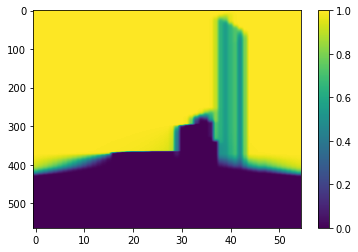

In [106]:
plt.imshow(np.exp(-tau_lambda_new_DRRE.T),aspect='auto')
plt.colorbar()

In [105]:
tau_lambda_new_DRRE.shape, Chi_new_DRRE[X_pix,Y_pix,:,20:75].dropna('height').shape

((55, 564), (564, 55))

## Factors to be included in the Contribution function analysis

In [58]:
chi_factor_new_DRRE = (Chi_new_DRRE[X_pix,Y_pix,:,20:75].dropna('height').T/tau_lambda_new_DRRE)
tau_factor_new_DRRE = tau_lambda_new_DRRE*np.exp(-tau_lambda_new_DRRE)
S_factor_new_DRRE = S_new_DRRE[X_pix,Y_pix,:,20:75].dropna('height').T
C_I_DRRE = S_factor_new_DRRE*tau_factor_new_DRRE*chi_factor_new_DRRE

## Spectral and spatial convolution

In [61]:
#Spatial convolution for each wavelength position per unit time with an FWHM of 0.08 arcsec
#Saptial sampling of the simulation is ~4 km and the spatial resolution of CHROMIS is ~60 km. Assuming an FWHM of 60 km, leads to a standard
# deviation that is given by 60/2.335 km ~ 7 pixels in the x direction in the simulation. Hence defining a Gaussian kernel with a std dev =7
# Performing a 1D spatial convolution for all x position per unit time for each wavelength position with the Astropy convolve function.
from astropy.convolution import Gaussian1DKernel,convolve
gauss_kernel = Gaussian1DKernel(2)
space_conv_CaK_DRRE = np.zeros((10,6,55)) #Same as (10, 3, 55)
#space_conv_tau_Cak = np.zeros((10,3,55))
for time in range(6):
    for wav in range(55):
        space_conv_CaK_DRRE[:,time,wav] = convolve(I_sp_DRRE[:,time,indices[wav+20]],gauss_kernel,normalize_kernel=True,boundary='extend')
 #       space_conv_tau_Cak[:,time,wav] = convolve(tau_comb[:,time,indices[wav+20]],gauss_kernel,normalize_kernel=True,boundary='extend')

In [62]:
#Spectral convolution per time step per unit x-position.
# First spatial smeraing and then spectral smearing as per the light path in the telescope.
F_tran=readsav('/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/crispex/09:12:00/Ca_K_FP_profile2.sav')
FP=np.array(F_tran['res2'])
FP= FP/np.sum(FP)
# F_tran_8542=readsav('/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/crispex/09:12:00/Ca_8542_FP_profile.sav')
# FP_8542=np.array(F_tran_8542['tr1'])
# FP_8542= FP_8542/np.sum(FP_8542)
# spec_conv_Ca_8542 = np.zeros((size_intensity[0],size_intensity[1],83))
spec_conv_CaH_K_DRRE = np.zeros((10,6,55))
# spec_conv_tau_Cak = np.zeros((size_intensity[0],size_intensity[1],55))
# spec_conv_tau_Ca8542 = np.zeros((size_intensity[0],size_intensity[1],83))
for time in range(6):
    for x_space in range(10):
        spec_conv_CaH_K_DRRE[x_space,time,:]=convolve(space_conv_CaK_DRRE[x_space,time,:],FP,boundary='extend')
#         spec_conv_tau_Cak[x_space,time,:]=convolve(space_conv_tau_Cak[x_space,time,:],FP,boundary='extend')
#         spec_conv_Ca_8542[x_space,time,:]=convolve(space_conv_Ca8542[x_space,time,:],FP_8542,boundary='extend')
#         spec_conv_tau_Ca8542[x_space,time,:]=convolve(space_conv_tau_Ca8542[x_space,time,:],FP_8542,boundary='extend')
        

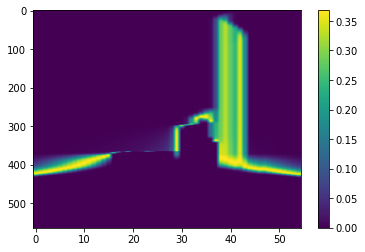

In [96]:
plt.imshow(tau_factor_new_DRRE.T,aspect='auto')
plt.colorbar()

In [77]:
#======== Converting specific intensity to brightness temperature ======##
T_brightness_DRRE = np.zeros((55))
for wl in range(55):
    T_brightness_DRRE[wl] = radiation_temperature(lambda_ref=wave_Ca[indices[20+wl]]*1e-9, I_sp=np.mean(spec_conv_CaH_K_DRRE[X_pix-1:X_pix+1,Y_pix,wl],axis=0))

## Ca II ionization 

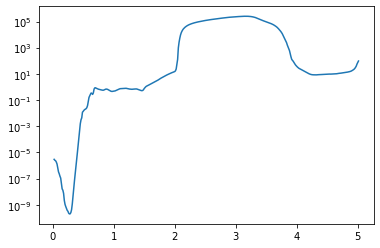

In [71]:
continuum_DRRE = dataCa_DRRE_ray_aux.atom_CA.populations[5,X_pix,Y_pix,989:1410]
tot_caII_DRRE = np.sum(dataCa_DRRE_ray_aux.atom_CA.populations[0:4,X_pix,Y_pix,989:1410],axis=0)

plt.plot(z1[989:1410],continuum_DRRE/tot_caII_DRRE)
plt.yscale('log')

In [72]:
z1[989:1410].shape

(421,)

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_innches" which is no longer supported as of 3.3 and will become an error two minor releases later


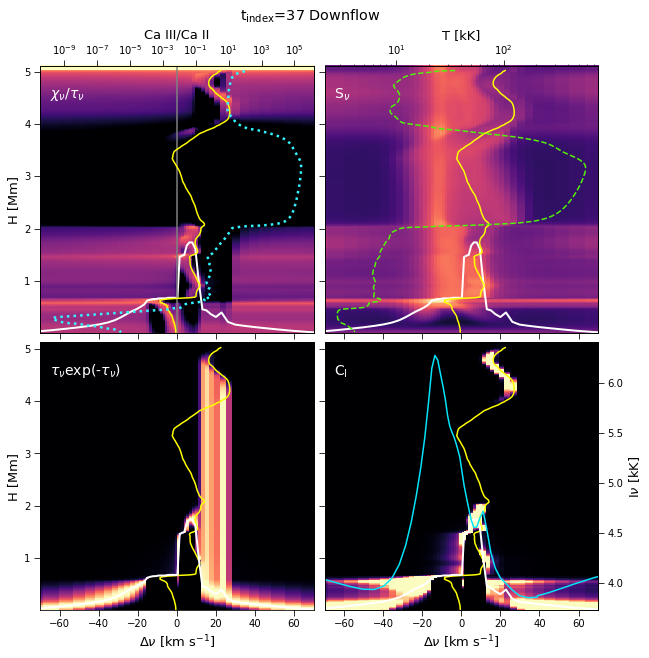

In [108]:
xdopp_minmax=[-70,70]
cmap1 = 'magma'
fig, axs =plt.subplots(2,2,figsize=(10,10),facecolor='w', edgecolor='k')
fig.suptitle(r't$_{\mathrm{index}}$=37 Downflow',va='center',y=0.95,size='x-large')
fig.subplots_adjust(hspace = 0.04,wspace=0.04)
axs=axs.ravel()

norm1 = cm.colors.Normalize(vmax=-3, vmin=-7)
im0 = NonUniformImage(axs[0], interpolation='nearest', extent=[xdopp_minmax[0],xdopp_minmax[1],z1[1410],z1[989]],cmap=cmap1,norm=norm1)
im0.set_data(x1,z1[:989:-1],np.flipud(np.squeeze(np.log10(chi_factor_new_DRRE.T))))
axs[0].set_xlim(-70,70)
axs[0].set_ylim(z1[1410],5.11)
axs[0].images.append(im0)    
axs[0].plot(dopp_cak,Tau_ht_new_DRRE[X_pix,Y_pix,indices[20:75]]/1e6,color='white',linewidth=2)
axs[0].axvline(x=0, color='gray')
axs[0].text(-65,4.5,r'$\chi_{\nu}$/$\tau_{\nu}$',color='white',size=14)
axs[0].plot(-1*vel_juan[0,4866,37,989:1410]/1e3,z1[989:1410],color='yellow')
axs[0].set_ylabel('H [Mm]',fontsize=13)
axs[0].set_xticklabels([])
axs[0].tick_params(direction='out', length=6,color='black')

ax0=axs[0].twiny()
#color ='tab:black'
ax0.set_xlabel(r'Ca III/Ca II',fontsize=13)
ax0.plot(continuum_DRRE/tot_caII_DRRE,z1[989:1410],color='#33F6FF', linestyle='dotted',linewidth=2.5)
ax0.set_xscale('log')
ax0.tick_params(direction='out', length=6,color='black')


norm2 = cm.colors.Normalize(vmax=-7.5,vmin=-10)
im1 = NonUniformImage(axs[1], interpolation='nearest', extent=[xdopp_minmax[0],xdopp_minmax[1],z1[1410],z1[989]],cmap=cmap1,norm=norm2)
im1.set_data(x1,z1[:989:-1],np.flipud(np.squeeze(np.log10(S_factor_new_DRRE.T))))
axs[1].set_xlim(-70,70)
axs[1].set_ylim(z1[1410],5.11)
axs[1].images.append(im1)    
axs[1].plot(dopp_cak,Tau_ht_new_DRRE[X_pix,Y_pix,indices[20:75]]/1e6,color='white',linewidth=2)
axs[1].text(-65,4.5,r'S$_{\nu}$',color='white',size=14)
axs[1].plot(-1*vel_juan[0,4866,37,989:1410]/1e3,z1[989:1410],color='yellow')
axs[1].tick_params(direction='out', length=6,color='black')
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])

ax2=axs[1].twiny()
#color ='tab:black'
ax2.set_xlabel('T [kK]',fontsize=13)
ax2.plot(temp_juan[0,4866,37,989:1410]/1e3,z1[989:1410],color='#52F208', linestyle='dashed')
ax2.set_xscale('log')
ax2.tick_params(direction='out', length=6,color='black')

norm3 = cm.colors.Normalize(vmax=0.35, vmin=0)
im2 = NonUniformImage(axs[2], interpolation='nearest', extent=[xdopp_minmax[0],xdopp_minmax[1],z1[1410],z1[989]],cmap=cmap1,norm=norm3)
im2.set_data(x1,z1[:989:-1],np.flipud(np.squeeze((tau_factor_new_DRRE.T))))
axs[2].set_xlim(-70,70)
axs[2].set_ylim(z1[1410],5.11)
axs[2].images.append(im2)
axs[2].text(-65,4.5,r'$\tau_{\nu}$exp(-$\tau_{\nu}$)',color='white',size=14)
axs[2].plot(-1*vel_juan[0,4866,37,989:1410]/1e3,z1[989:1410],color='yellow')
axs[2].plot(dopp_cak,Tau_ht_new_DRRE[X_pix,Y_pix,indices[20:75]]/1e6,color='white',linewidth=2)
axs[2].tick_params(direction='out', length=6,color='black')
axs[2].set_ylabel('H [Mm]',fontsize=13)
axs[2].set_xlabel(r'$\Delta$$\nu$ [km s$^{-1}$]',fontsize=13)

norm4 = cm.colors.Normalize(vmax=7e-16, vmin=0)
im3 = NonUniformImage(axs[3], interpolation='nearest', extent=[xdopp_minmax[0],xdopp_minmax[1],z1[1410],z1[989]],cmap=cmap1,norm=norm4)
im3.set_data(x1,z1[:989:-1],np.flipud(np.squeeze((C_I_DRRE.T))))
axs[3].set_xlim(-70,70)
axs[3].set_ylim(z1[1410],5.11)
axs[3].images.append(im3)
axs[3].text(-65,4.5,r'C$_{\mathrm{I}}$',color='white',size=14)
axs[3].plot(-1*vel_juan[0,4866,37,989:1410]/1e3,z1[989:1410],color='yellow')
axs[3].plot(dopp_cak,Tau_ht_new_DRRE[X_pix,Y_pix,indices[20:75]]/1e6,color='white',linewidth=2)
axs[3].tick_params(direction='out', length=6,color='black')
axs[3].set_yticklabels([])
axs[3].set_xlabel(r'$\Delta$$\nu$ [km s$^{-1}$]',fontsize=13)

ax3=axs[3].twinx()
#color ='tab:black'
ax3.set_ylabel(r'I$\nu$ [kK]',fontsize=13)
ax3.plot(dopp_cak,T_brightness_DRRE/1e3,color='#03E5FA')
ax3.tick_params(direction='out', length=6,color='black')
plt.savefig('/mn/stornext/d9/souvikb/paper5_results/Cont_func_DRRE_Ca.pdf',dpi=400,format='pdf',bbox_inches = 'tight',pad_innches=0.1)

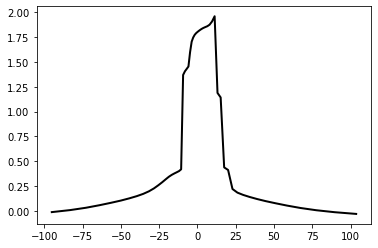

In [93]:
plt.plot(dopp_cak,Tau_ht_new_DRRE[8,0,indices[20:75]]/1e6,color='black',linewidth=2)

In [109]:
Chi_new_DRRE[X_pix,Y_pix,:,20:75].dropna('height').shape

(564, 55)

In [120]:
dopp_cak[40]

<xarray.DataArray 'wavelength' ()>
array(17.428806)
Coordinates:
    wavelength  float64 393.4

In [131]:
wave_Ca[indices[20+40]]

<xarray.DataArray 'wavelength' ()>
array(393.392853)
Coordinates:
    wavelength  float64 393.4
Attributes:
    units:    nm

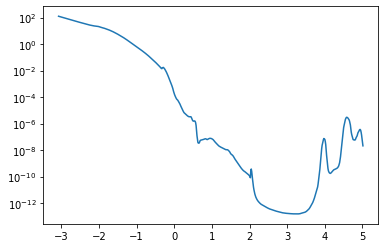

In [150]:
plt.plot(dataCa_DRRE_ray_aux.atmos.height_scale[6, 2].dropna('height')/1e6,Chi_new_DRRE[X_pix,Y_pix,:,60].dropna('height'))
plt.yscale('log')

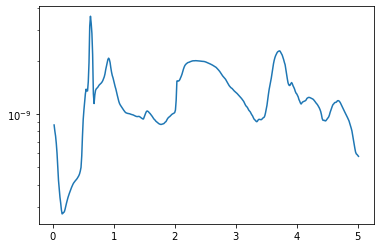

In [135]:
plt.plot(z1[989:1410],S_new_DRRE[X_pix,Y_pix,989:1410,60])
plt.yscale('log')

In [140]:
S_new_DRRE[X_pix,Y_pix,989:1410,:].shape

(421, 188)

In [134]:
indices.shape

(188,)

In [144]:
#======== Converting Source function to brightness temperature ======##
S_brightness_DRRE = np.zeros((421))
for z in range(421):
    S_brightness_DRRE[z] = radiation_temperature(lambda_ref=wave_Ca[indices[20+40]]*1e-9, I_sp=np.mean(S_new_DRRE[X_pix-1:X_pix+1,Y_pix,989+z,60],axis=0))

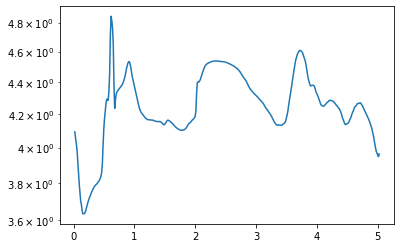

In [146]:
plt.plot(z1[989:1410], S_brightness_DRRE/1e3)
plt.yscale('log')

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


(2.1425181161946987, 15)

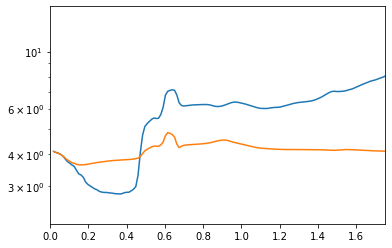

In [155]:
plt.plot(z1[989:1410],temp_juan[0,4866,37,989:1410]/1e3)
plt.plot(z1[989:1410], S_brightness_DRRE/1e3)
plt.xlim([0,1.75])
plt.yscale('log')
plt.ylim([0,15])